In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Fig. 4b, top

In [2]:
# read drug administration records
df_drug = pd.read_csv('tbldrug.csv')
df_drug = df_drug[df_drug.AntiInfective==True].reset_index(drop=True)

# convert to single day entry
df_drug_single_day = []
for index in df_drug.index:
    start_tps = df_drug.loc[index,'StartTimepoint']
    stop_tps = df_drug.loc[index,'StopTimepoint']
    start_day = df_drug.loc[index,'StartDayRelativeToNearestHCT']
    for timepoint in np.arange(start_tps,stop_tps+1):
        res = list(df_drug.loc[index])
        res.append(timepoint)
        res.append(timepoint-start_tps+start_day)
        df_drug_single_day.append(res)
df_drug_single_day = pd.DataFrame(df_drug_single_day, columns=list(df_drug.columns)+['Timepoint','DayRelativeToNearestHCT'])
df_drug_single_day = df_drug_single_day.drop(['StartTimepoint','StopTimepoint','StartDayRelativeToNearestHCT','StopDayRelativeToNearestHCT'], axis=1)
df_drug = deepcopy(df_drug_single_day)
df_drug = df_drug[df_drug.DayRelativeToNearestHCT.notnull()]
df_drug = df_drug.drop_duplicates()

# only keep antibiotics
df_drug = df_drug[df_drug.Category.isin(['aminoglycosides','carbapenems','cephalosporins','glycopeptide antibiotics','glycylcyclines',
                                         'leprostatics','lincomycin derivatives','macrolide derivatives','miscellaneous antibiotics',
                                         'oxazolidinone antibiotics', 'penicillins','quinolones','sulfonamides','tetracyclines'])]

# restructure drugs for downstream analysis
df_drug['GroupLabel'] = 'other'

# change vancomycin to oral vanco and iv vanco
df_drug.loc[(df_drug.Factor=='vancomycin')&(df_drug.Route=='oral'), 'GroupLabel'] = 'vancomycin_oral'
df_drug.loc[(df_drug.Factor=='vancomycin')&(df_drug.Route=='intravenous'), 'GroupLabel'] = 'vancomycin_iv'

# change sulfamethoxazole trimethoprim to sulfamethoxazole/trimethoprim
df_drug.loc[df_drug.Factor=='sulfamethoxazole trimethoprim', 'Factor'] = 'sulfamethoxazole/trimethoprim'

# set the following factors as independent groups
for f in ['amoxicillin clavulanate','piperacillin/tazobactam','metronidazole','clindamycin',
          'tigecycline','linezolid','sulfamethoxazole/trimethoprim','doxycycline','aztreonam']:
    df_drug.loc[df_drug.Factor==f, 'GroupLabel'] = f
    
# set the following categories as independent groups
for c in ['carbapenems','aminoglycosides','cephalosporins','macrolide derivatives','quinolones']:
    df_drug.loc[df_drug.Category==c, 'GroupLabel'] = c

# select relevant columns
df_drug = df_drug[['PatientID','GroupLabel','DayRelativeToNearestHCT','Timepoint']]

# print unique drug groups
class2include = list(set(df_drug.GroupLabel))

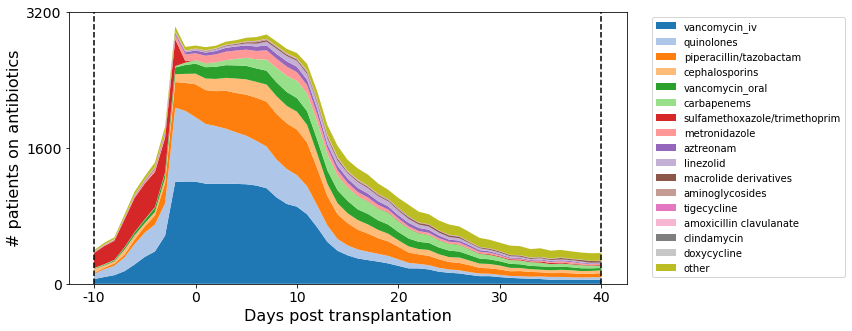

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharex=True)

# calculate the number of patients on each day receiving antibiotics
df_drug_usage = deepcopy(df_drug)
df_drug_usage['PatientID'] = 1
df_drug_usage = df_drug_usage[(df_drug_usage.DayRelativeToNearestHCT>=-10) & (df_drug_usage.DayRelativeToNearestHCT<=40)]
df_drug_usage = df_drug_usage.groupby(['GroupLabel','DayRelativeToNearestHCT']).agg(sum).reset_index()
df_drug_usage = pd.pivot_table(df_drug_usage, values='PatientID', index='DayRelativeToNearestHCT', columns='GroupLabel').fillna(0)

# sort drug categories based on the mean number of patients receiving the drugs
df_drug_usage_T = df_drug_usage.T
df_drug_usage_T['mean'] = df_drug_usage_T.mean(axis=1)
df_drug_usage_T = df_drug_usage_T.sort_values(by=['mean'],axis=0,ascending=False)
df_drug_usage_T = df_drug_usage_T.drop('mean', axis=1)
df_drug_usage = df_drug_usage_T.T

# move other to the last column
df_drug_usage = df_drug_usage.drop(columns=['other']).assign(other=df_drug_usage['other'])

# plot fraction of patients receiving drug administration
x = list(df_drug_usage.index)
y = df_drug_usage.T.values
_ = ax.stackplot(x,y, labels=df_drug_usage.columns, colors=sns.color_palette("tab20"))
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0))
ax.plot([-10,-10],[0,3200],'k--')
ax.plot([40,40],[0,3200],'k--')
_ = ax.set_ylim([0,3200])
_ = ax.set_yticks([0,1600,3200])
_ = ax.set_yticklabels([0,1600,3200], fontsize=14)
_ = ax.set_ylabel('# patients on antibiotics', fontsize=16)
_ = ax.set_xticks([-10,0,10,20,30,40])
_ = ax.set_xticklabels([-10,0,10,20,30,40], fontsize=14)
_ = ax.set_xlabel('Days post transplantation', fontsize=16)

# Fig. 4b (middle and bottom)

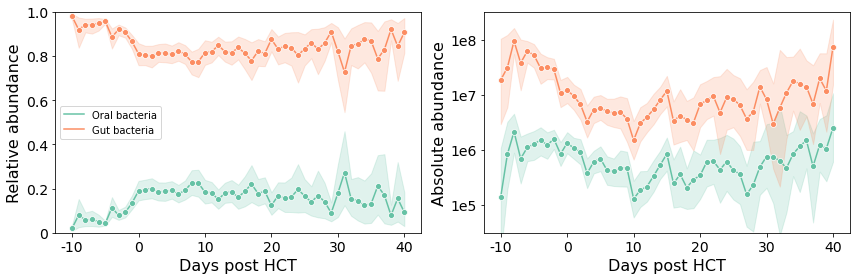

In [4]:
# read sample meta data and eliminate samples without transplant day
# constrain samples to be collected between [-10, 40]
df_sample = pd.read_csv('tblASVsamples.csv', index_col=0)
df_sample = df_sample[(df_sample.DayRelativeToNearestHCT>=-10) & (df_sample.DayRelativeToNearestHCT<=40)]

# read count data
df_count = pd.read_csv('tblcounts_asv_melt.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_relab =  df_count.div(df_count.sum(axis=1), axis=0)

# find commmon samples
common_samples = set(df_sample.index).intersection(set(df_relab.index))
df_sample = df_sample.loc[common_samples]
df_relab = df_relab.loc[common_samples]

# read taxanomy table
df_tax = pd.read_csv('tblASVtaxonomy_silva138_v4v5_filter.csv', index_col=0)

# read qpcr
df_qpcr = pd.read_csv('tblqpcr.csv', index_col=0)
df_qpcr = df_qpcr[df_qpcr.qPCR16S>0]

# calculate absolute abundance
df_absab = pd.merge(df_relab, df_qpcr, how='inner', left_index=True, right_index=True)
df_absab = df_absab.mul(df_absab['qPCR16S'], axis=0)
df_absab = df_absab.drop(columns=['qPCR16S']).T

# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
df_oral_total = df_relab[set(df_blast_100.query_accver).intersection(df_relab.columns)].sum(axis=1).to_frame()
df_oral_total.columns = ['OralFrac_HMPv35oral']
df_oral_total = pd.merge(df_oral_total, df_qpcr, how='inner', left_index=True, right_index=True)
df_oral_total['OralLoad_HMPv35oral'] = df_oral_total['OralFrac_HMPv35oral'].mul(df_oral_total['qPCR16S'], axis=0)
df_oral_total['GutFrac_HMPv35oral'] = 1-df_oral_total['OralFrac_HMPv35oral']
df_oral_total['GutLoad_HMPv35oral'] = df_oral_total['GutFrac_HMPv35oral'].mul(df_oral_total['qPCR16S'], axis=0)
df_oral_total = df_oral_total.drop(columns=['qPCR16S'])

df = pd.merge(df_sample, df_oral_total, left_index=True, right_index=True, how='inner')
df['log10_OralLoad_HMPv35oral'] = np.log10(df['OralLoad_HMPv35oral'])
df['log10_GutLoad_HMPv35oral'] = np.log10(df['GutLoad_HMPv35oral'])
df = df[df.OralFrac_HMPv35oral > 0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharex=True)

df2plot = df.set_index('DayRelativeToNearestHCT')[['OralFrac_HMPv35oral','GutFrac_HMPv35oral']].stack().reset_index()
df2plot = df2plot.replace({'OralFrac_HMPv35oral':'Oral bacteria','GutFrac_HMPv35oral':'Gut bacteria'})
df2plot.columns = ['DayRelativeToNearestHCT', 'BodySite', 'Fraction']
_ = sns.lineplot(x="DayRelativeToNearestHCT", y="Fraction", hue='BodySite', data=df2plot, ax=ax[0], palette='Set2', marker='o')
_ = ax[0].legend(loc='center left')

df2plot = df.set_index('DayRelativeToNearestHCT')[['log10_OralLoad_HMPv35oral','log10_GutLoad_HMPv35oral']].stack().reset_index()
df2plot.columns = ['DayRelativeToNearestHCT', 'BodySite', 'Load']
_ = sns.lineplot(x="DayRelativeToNearestHCT", y="Load", hue='BodySite', data=df2plot, ax=ax[1], palette='Set2', marker='o')
_ = ax[1].legend().remove()

_ = ax[0].set_xlabel('Days post HCT', fontsize=16)
_ = ax[1].set_xlabel('Days post HCT', fontsize=16)
_ = ax[0].set_ylim([0,1])
_ = ax[1].set_ylim([4.5,8.5])
_ = ax[0].set_ylabel('Relative abundance', fontsize=16)
_ = ax[1].set_ylabel('Absolute abundance', fontsize=16)

_ = ax[0].set_xticks([-10,0,10,20,30,40])
_ = ax[0].set_xticklabels([-10,0,10,20,30,40], fontsize=14)
_ = ax[1].set_xticks([-10,0,10,20,30,40])
_ = ax[1].set_xticklabels([-10,0,10,20,30,40], fontsize=14)
_ = ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
_ = ax[0].set_yticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize=14)
_ = ax[1].set_yticks([5,6,7,8])
_ = ax[1].set_yticklabels(['1e5','1e6','1e7','1e8'], fontsize=14)

plt.tight_layout()